# Data Module Performance Benchmarking

In [1]:

from data.datamodule import PFresGODataset
from pathlib import Path

    # def __init__(
    #     self,
    #     protein_ids: List[str]
    #     residue_emb_file: Path,
    #     go_emb_file: Path,
    #     ontology_file: Path, # OBO file
    #     annot_file: Path,
    #     subontology: Literal['molecular_function', 'biological_process', 'cellular_component', 'all'],


ModuleNotFoundError: No module named 'data'

In [3]:

prots = open("datasets/pfresgo/train.txt").read().splitlines()

In [7]:
%load_ext line_profiler


In [5]:
def load_ds():
  return PFresGODataset(
    protein_ids=prots,
    residue_emb_file=Path("datasets/pfresgo/per_residue_embeddings.h5"),
    go_emb_file=Path("datasets/pfresgo/ontology.embeddings.npy"),
    ontology_file=Path("datasets/pfresgo/go.obo"),
    annot_file=Path("datasets/pfresgo/annot.tsv"),
    subontology="molecular_function",
  )
%lprun -f PFresGODataset.__init__ load_ds()

Timer unit: 1e-09 s

Total time: 7.49027 s
File: /Users/mmtf/p/research/contempro/work/data/datamodule.py
Function: __init__ at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def __init__(
    41                                                   self,
    42                                                   protein_ids: List[str],
    43                                                   residue_emb_file: Path,
    44                                                   go_emb_file: Path,
    45                                                   ontology_file: Path, # OBO file
    46                                                   annot_file: Path,
    47                                                   subontology: Literal['molecular_function', 'biological_process', 'cellular_component', 'all'],
    48                                               ):
    49                                                   """

# Ordering Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[12/23/24 18:43:45] WARNING  2024-12-23 18:43:45 | WARNING  |                                     ]8;id=682169;file:///Users/mmtf/p/research/contempro/work/notebooks/../data/datamodule.py\datamodule.py]8;;\:]8;id=347101;file:///Users/mmtf/p/research/contempro/work/notebooks/../data/datamodule.py#242\242]8;;\
                             data.datamodule:_generate_go_terms_bfs:242 - Remaining terms: 2279                    

First 10 GO terms:
1. GO:0003674
2. GO:0003774
3. GO:0003824
4. GO:0005198
5. GO:0005215
6. GO:0005488
7. GO:0009055
8. GO:0016209
9. GO:0038024
10. GO:0044183


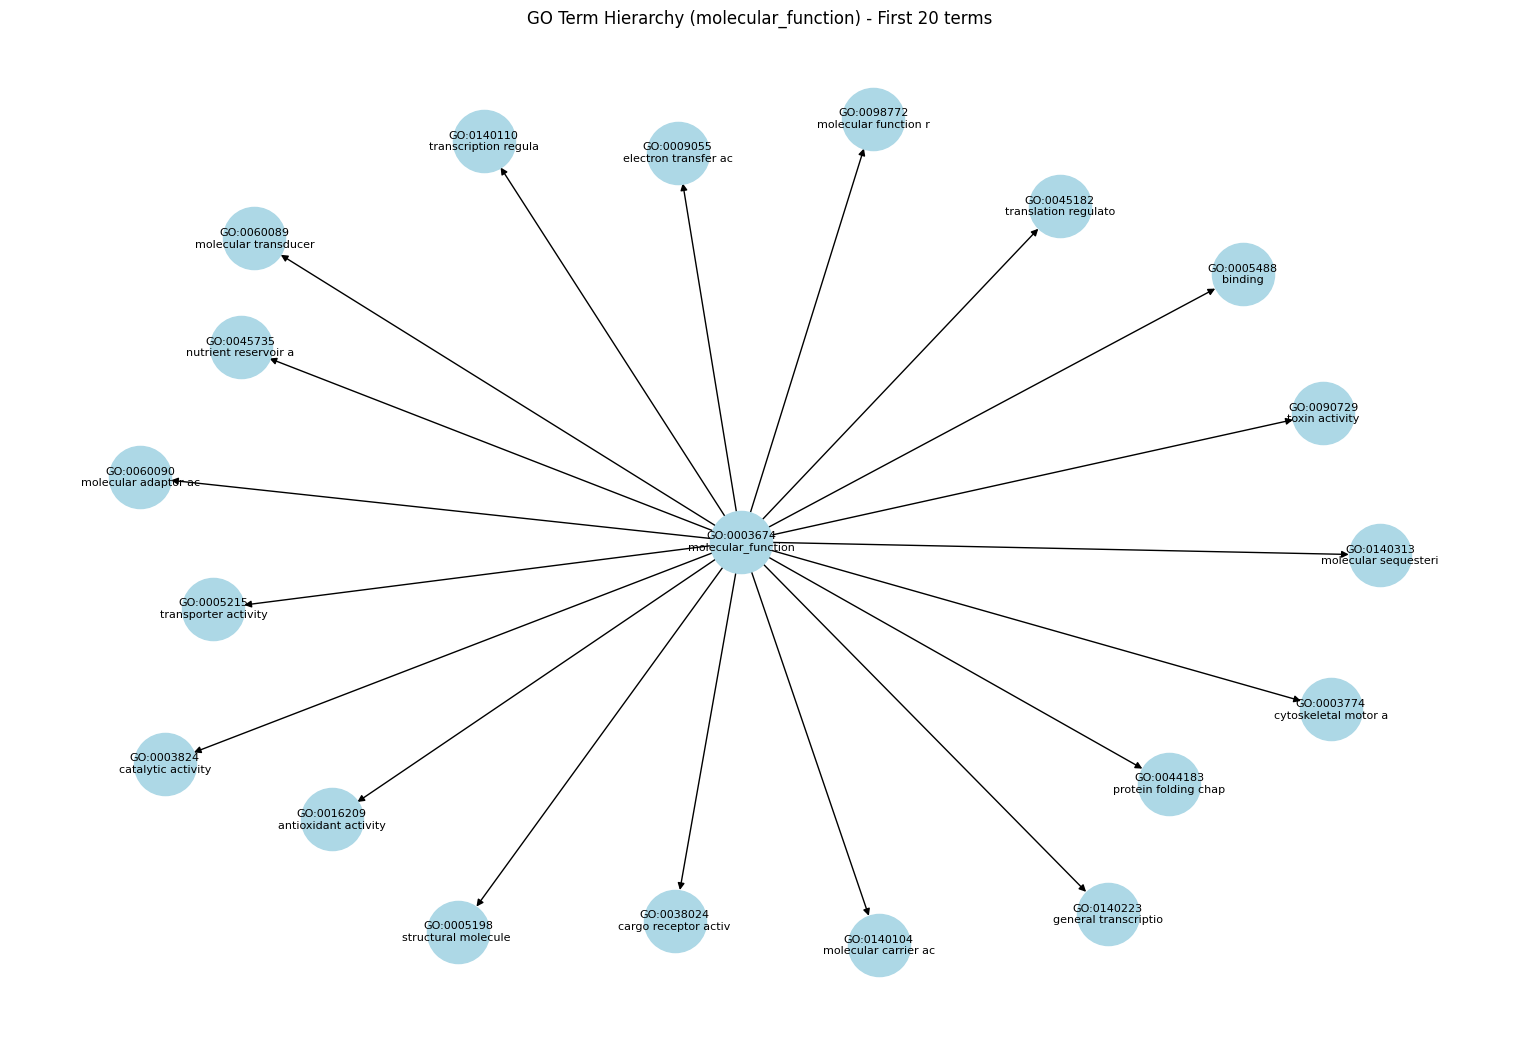

[12/23/24 18:43:48] WARNING  2024-12-23 18:43:48 | WARNING  |                                     ]8;id=775271;file:///Users/mmtf/p/research/contempro/work/notebooks/../data/datamodule.py\datamodule.py]8;;\:]8;id=476033;file:///Users/mmtf/p/research/contempro/work/notebooks/../data/datamodule.py#242\242]8;;\
                             data.datamodule:_generate_go_terms_bfs:242 - Remaining terms: 2279                    


Comparison of first 10 terms:

Ordered terms:
1. GO:0003674
2. GO:0003774
3. GO:0003824
4. GO:0005198
5. GO:0005215
6. GO:0005488
7. GO:0009055
8. GO:0016209
9. GO:0038024
10. GO:0044183

Unordered terms:
1. GO:0000005
2. GO:0000006
3. GO:0000007
4. GO:0000008
5. GO:0000009
6. GO:0000010
7. GO:0000014
8. GO:0000016
9. GO:0000026
10. GO:0000030

Total number of terms:
Ordered: 12644
Unordered: 12644


In [5]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import fastobo

sys.path.append("..")
# Assuming your project root is in the path
from data.datamodule import PFresGODataModule

# Test configuration
config = {
    'data_dir': '../datasets/pfresgo',  # adjust to your data directory
    'batch_size': 32,
    'num_workers': 0,
    'ontology': 'molecular_function',  # try with different ontologies: 'biological_process', 'cellular_component'
    'go_release': '2024',
    'order_go_terms': True  # Compare with False
}

# Initialize DataModule
dm = PFresGODataModule(**config)

# Setup the datamodule
dm.setup('test')

# Get the ordered GO terms from the training dataset
ordered_terms = dm.test_dataset.go_term_list

# Print first few terms
print("First 10 GO terms:")
for i, term in enumerate(ordered_terms[:10]):
    print(f"{i+1}. {term}")

# Visualize a subset of the GO hierarchy
def visualize_go_hierarchy(obo_file, subontology, n_terms=20):
    """
    Visualize the first n_terms of the GO hierarchy.
    """
    # Load ontology
    doc = fastobo.load(obo_file.open('rb'))

    # Create graph
    G = nx.DiGraph()

    # Map terms to namespaces
    term_namespaces = {}
    term_names = {}  # Store term names for better visualization
    for frame in doc:
        if isinstance(frame, fastobo.term.TermFrame):
            term_id = str(frame.id)
            for clause in frame:
                if isinstance(clause, fastobo.term.NamespaceClause):
                    term_namespaces[term_id] = str(clause.namespace)
                elif isinstance(clause, fastobo.term.NameClause):
                    term_names[term_id] = str(clause.name)

    # Add edges for the first n_terms
    terms_to_show = set(ordered_terms[:n_terms])
    for frame in doc:
        if isinstance(frame, fastobo.term.TermFrame):
            term_id = str(frame.id)
            if term_id in terms_to_show:
                for clause in frame:
                    if isinstance(clause, fastobo.term.IsAClause):
                        parent_id = str(clause.term)
                        if parent_id in terms_to_show:
                            G.add_edge(parent_id, term_id)

    # Plot
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1, iterations=50)
    nx.draw(G, pos, with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=8,
            labels={node: f"{node}\n{term_names.get(node, '')[:20]}" for node in G.nodes()})
    plt.title(f"GO Term Hierarchy ({subontology}) - First {n_terms} terms")
    plt.show()

# Visualize the hierarchy
obo_file = Path(config['data_dir']) / "go.obo"
visualize_go_hierarchy(obo_file, config['ontology'], n_terms=20)

# Compare term ordering
def compare_orderings(dm):
    """
    Compare ordered vs unordered GO terms
    """
    # Get ordered terms
    ordered_dm = PFresGODataModule(**{**config, 'order_go_terms': True})
    ordered_dm.setup('test')
    ordered_terms = ordered_dm.test_dataset.go_term_list

    # Get unordered terms
    unordered_dm = PFresGODataModule(**{**config, 'order_go_terms': False})
    unordered_dm.setup('test')
    unordered_terms = unordered_dm.test_dataset.go_term_list

    print("\nComparison of first 10 terms:")
    print("\nOrdered terms:")
    for i, term in enumerate(ordered_terms[:10]):
        print(f"{i+1}. {term}")

    print("\nUnordered terms:")
    for i, term in enumerate(unordered_terms[:10]):
        print(f"{i+1}. {term}")

    print(f"\nTotal number of terms:")
    print(f"Ordered: {len(ordered_terms)}")
    print(f"Unordered: {len(unordered_terms)}")

    return ordered_terms, unordered_terms

# Compare orderings
ordered_terms, unordered_terms = compare_orderings(dm)


In [20]:
ordering = {term: i for i, term in enumerate(ordered_terms)}

In [15]:
sum(abs(i-ordering[term]) for i, term in enumerate(ordered_terms))/len(ordered_terms)**2


0.3533145553292505

In [21]:
import plotly.express as px



#px.scatter(x=ordered_terms, y=[ordering[term] for term in ordered_terms])
px.scatter(x=unordered_terms, y=[ordering[term] for term in unordered_terms])


# Annotations in Graph

Here, I compare the annotations that we have and whether they're connected or disconnected from the main graph. This happens when the annotated GO ID is a secondary GO id for another term in the graph or when the GO term is obsolete.


In [2]:
import pandas as pd

df = pd.read_csv("../datasets/pfresgo/annot.tsv", sep="\t", skiprows=12).fillna('')

df.head()

,### PDB-chain,GO-terms (molecular_function),GO-terms (biological_process),GO-terms (cellular_component)
0,11AS-A,"GO:0097367,GO:0042802,GO:0016879,GO:0032559,GO...","GO:0016053,GO:1901607,GO:0006950,GO:0032787,GO...",GO:0005829
1,154L-A,"GO:0004553,GO:0003796,GO:0061783,GO:0016798","GO:0006950,GO:0042742,GO:0044248,GO:0006022,GO...",GO:0005576
2,155C-A,"GO:0009055,GO:0046906,GO:0020037","GO:0006091,GO:0022900",
3,16PK-A,"GO:0016772,GO:0016301,GO:0097367,GO:0032559,GO...","GO:0009135,GO:0046939,GO:0016052,GO:0019637,GO...","GO:0005777,GO:0042579"
4,16VP-A,GO:0003677,"GO:0009889,GO:0051171,GO:0019219,GO:2000112,GO...",


In [3]:

import numpy as np

x = df.iloc[:, 1:4].to_numpy().astype(str)
x = np.char.split(x, ",")
x.shape

(36641, 3)

In [4]:
import itertools


all_annot_terms = list(itertools.chain.from_iterable(itertools.chain.from_iterable(x)))


In [11]:
from pathlib import Path
ontology_paths = [Path("../datasets/pfresgo/2020-go.obo"), Path("../datasets/pfresgo/go.obo")]
import fastobo
import networkx as nx
 # Load ontology
def load_graph(ontology_path):
    doc = fastobo.load(ontology_path.open('rb'))

    # Create graph
    G = nx.DiGraph()

    # Map terms to namespaces
    term_namespaces = {}
    term_names = {}  # Store term names for better visualization
    for frame in doc:
        if isinstance(frame, fastobo.term.TermFrame):
            term_id = str(frame.id)
            for clause in frame:
                if isinstance(clause, fastobo.term.NamespaceClause):
                    term_namespaces[term_id] = str(clause.namespace)
                elif isinstance(clause, fastobo.term.NameClause):
                    term_names[term_id] = str(clause.name)

    # Add edges for the first n_terms
    for frame in doc:
        if isinstance(frame, fastobo.term.TermFrame):
            term_id = str(frame.id)
            for clause in frame:
                if isinstance(clause, fastobo.term.IsAClause):
                    parent_id = str(clause.term)
                    G.add_edge(term_id, parent_id)

    return G

In [7]:
def evaluate_annotations(ontology_path):
    graph = load_graph(ontology_path)

    annot_in_graph = sum(1 for term in all_annot_terms if term in graph and len(graph[term]) > 0)

    annot_not_in_graph = len([term for term in all_annot_terms if term not in graph])
    annot_not_in_graph

    return {
        "annot_in_graph": annot_in_graph,
        "annot_not_in_graph": annot_not_in_graph,
        "annot_in_graph_ratio": annot_in_graph / len(all_annot_terms),
        "annot_not_in_graph_ratio": annot_not_in_graph / len(all_annot_terms),
    }



In [14]:
results = []
for ontology_path in ontology_paths:
    result = evaluate_annotations(ontology_path)
    result.update({"ontology": ontology_path.name})
    results.append(result)

import pandas as pd

pd.DataFrame(results).set_index('ontology')


,annot_in_graph,annot_not_in_graph,annot_in_graph_ratio,annot_not_in_graph_ratio
ontology,,,,
2020-go.obo,897694,33215,0.964320,0.035680
go.obo,823349,107560,0.884457,0.115543
